# DEMs, Charge Locations & Crater Profiles

**Needs**
    
  - Output from the {doc}`crater_dem_hillshade` notebook
  - Charge locations (currently hard coded)
    
**Provides**
    
  - Transformations form site-coordinate system to crater-centric coordinate
    systems for each pad.
  - DEMs and hillshade files in crater-centric coordinates.  
    Folder/filename: as above, with added `_ccoords` before the file extension.
  - Mapview/Profile plots with charge locations.
  

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import rasterio
from rasterio.plot import show
from rasterio import mask, DatasetReader
import fiona
import shapely
from shapely.geometry import box, LineString, LinearRing, Point
from shapely.affinity import translate, rotate
from affine import Affine
from pathlib import Path

from mapview import rotate_raster

plt.rc('figure', figsize=(12, 10))

In [2]:
pltt = sbn.color_palette(['#2271B2', '#D55E00', '#359B73', '#E20134',
                          '#A40122', '#000000', '#00C2F9'])
sbn.set_palette(pltt)
pltt

[(0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (0.0, 0.0, 0.0),
 (0.0, 0.7607843137254902, 0.9764705882352941)]

In [3]:
dataloc = Path('../data/UMKC')

## Helpers

### Spatial

#### `get_not_masked()`

Return all indices of a masked array (`arr`), that are not masked. 

In [4]:
def get_not_masked(arr):
    """Return all indices of `arr`, that are not masked.
    
    Parameters
    ----------
    arr : MaskedArray
    """
    idxy = np.array([[-1, -1]], dtype=int)
    idxraw = np.arange(arr.shape[1])
    for i in range(arr.shape[0]):
        idx = idxraw[~arr.mask[i, :]]
        chunk = np.empty((len(idx), 2), dtype=int)
        chunk[:, 0] = idx
        chunk[:, 1] = i
        idxy = np.concatenate((idxy, chunk))
    return idxy[1:]

#### `get_xy()`

Convert index values to (x, y) coordinates using given transform

In [5]:
def get_xy(idxa, transform):
    return np.array([list(transform * c) for c in idxa])

#### `site_to_cratercoords()`

Transform between the two coordinate systems

In [6]:
def site_to_cratercoords(coords, cntr, phi):
    """
    coords : shape (n, 2) array
        2d coordinates to transform.
    cntr : list
        coordinates (in the site system) of origin of crater crs.
    phi : float
        rotation angle (in degree)
    
    Returns
    -------
    A shape (n, 2) array of 2d crater centered coordinates.
    """
    return np.array([
        Affine.rotation(phi) * list(crd - cntr)
        for crd in coords
    ])

#### `orth_to_slice()`

Make a line orthogonal to a given slice (`box`)

In [7]:
def orth_to_slice(box):
    """Make a line orthogonal to a given slice (`box`)
    
    Parameters
    ----------
    box : shapely.geometry.box
    """
    x, y = box.exterior.xy
    x = np.asarray(x)
    y = np.asarray(y)
    return rotate(
        LineString(coordinates=[
            [x[:2].sum() / 2, y[:2].sum() / 2],
            [x[2:4].sum() / 2, y[2:4].sum() / 2]
        ]),
        90
    )

#### `get_crater_min()`

In [8]:
def get_crater_min(ds, window):
    """Find minimum of crater.
    
    Parameters
    ----------
    
    ds : Dataset
    window : tuple
        xy-values marking the window where to look for. Format:
        `((xstart, ystart), (xend, yend))`.
    
    Returns
    -------
    Dictionary with keys `rc`: row and column of minimum; 'xy' coordinates of
    minimum.
    """
    (xs, ys), (xe, ye) = window
    (rows, cols), (rowe, cole) = ds.index(xs, ys), ds.index(xe, ye)
    crater = ds.read(1, masked=True)[rows:rowe, cols:cole]
    (rowmin, *_), (colmin, *_) = np.where(crater == crater.min())
    return {
        'rc': (rowmin + rows, colmin + cols),
        'xy': np.asarray(ds.xy(rowmin + rows, colmin + cols))
    }

#### `find_crater_min()`

Same as above, but more complicated (probably can delete this...)

In [9]:
def find_crater_min(bxmn, bxmx, bymn, bymx, dem, ds):
    """
    Parameters
    ----------
    bxmn : float
        x-coordinate of left boundary.
    bxmx : float
        x-coordinate of right boundary.
    bymn : float
        y-coordinate of lower boundary.
    bymx : float
        y-coordinate of upper boundary.
    dem : MaskedArray
    ds : Dataset
        The dataset containing the dem.
    
    Returns
    -------
    tuple
        Returns (mn, (x_min, y_min)), where mn is the minimum elevation, and
        x_min, y_min are the corresponding coordinates (not the array indexes).
    """
    rll, cll = ds.index(bxmn, bymn)  # lower left
    rul, cul = ds.index(bxmn, bymx)  # upper left
    rur, cur = ds.index(bxmx, bymx)  # upper right
    rlr, clr = ds.index(bxmx, bymn)  # lower right

    print("boundary indexes:\n"
        f"             row  col\n"
        f"lower left:  {rll} {cll}\n"
        f"upper left:  {rul} {cul}\n"
        f"upper right: {rur} {cur}\n"
        f"lower right: {rlr} {clr}\n"
    )
    mn = dem[rul:rll, cll:cur].min()
    ((row, *_), (col, *_)) = np.where(dem == mn)
    cmin = np.asarray(ds.xy(row, col))
    return mn, cmin

### Plotting

#### `clr` – Little Color Container

In [10]:
pltt

[(0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (0.0, 0.0, 0.0),
 (0.0, 0.7607843137254902, 0.9764705882352941)]

In [11]:
class clr:
    prf1 = "#000000"
    prf2 = "#a0a0a0"
    prf3 = '#f5f5f5'
    chrg = pltt[3]
    blck = '#ffffff'
    hlp1 = pltt[6]

#### `show_dem() `

Show DEM & Charge Locations

In [12]:
def show_dem(ax, ds, ref, cc, org):
    show(ds, ax=ax, cmap=plt.cm.gray)
    ax.scatter(ref[:, 0], ref[:, 1], marker='x', color=clr.blck)
    ax.scatter(cc[:3, 0], cc[:3, 1], color=clr.chrg, marker='x')
    ax.plot(org[0], org[1], color='white', marker='o', fillstyle='none',
            ls='none')
    ax.set_xlabel(r'$x_\mathrm{site}\ /\ \mathrm{m}$')
    ax.set_ylabel(r'$y_\mathrm{site}\ /\ \mathrm{m}$')

#### `add_profs_to_dem()`

Plot profiles on top of a DEM.

In [13]:
def add_profs_to_dem(ax, box1, box2, ort, lbl=(r'$p_0$', r'$p_2$')):
    xtrx, xtry = box1.exterior.xy
    ax.plot(*box1.exterior.xy, color=clr.prf1, lw=.5)
    ax.annotate(lbl[0], (xtrx[0], xtry[0]), color=clr.prf1, va='center')

    ax.plot(*ort.xy, color=clr.hlp1)

    xtrx, xtry = box2.exterior.xy
    ax.plot(*box2.exterior.xy, color=clr.prf3, lw=.5)
    ax.annotate(lbl[1], (xtrx[0], xtry[0]), color=clr.prf3, va='center')

#### `dem_to_cratercoords()`

Rotate DEM so that raster lines are parallel (and perpendicular) to charge line.

In [14]:
def dem_to_cratercoords(
    ds: DatasetReader, cc: np.ndarray, setup: str = 'line',
    width: float = None, height: float = None, ret: str = None):
    """Transform a DEM to crater coordinates.
    Rotates DEM so that raster lines are parallel (and perpendicular) to charge
    lines.
    
    Parameters
    ----------
    ds : 
        Dataset to transform
    cc : 
        Charge coordinates (in the site coordinate system)
    setup : 
        one of 'line', 'triag'
    width, height : 
        Final width and height of new dataset in meters.
    ret : 
        Whether, and what to return. One of `None`, 'all', 'phi', 'transform',
        'fname', 'center'.
    """
    rv = {}
    if setup == 'line':
        cx, cy = cc[1]
    elif setup == 'triag':
        cx, cy = cc.sum(axis=0) / 3.
    rv['center'] = np.array([cx, cy])
    x1, x2 = cc[[0, 2], 0]
    y1, y2 = cc[[0, 2], 1]
    phi = -np.arctan((y2 - y1) / (x2 - x1)) * 180 / np.pi
    rv['phi'] = phi
    cir, cic = ds.index(cx, cy)
    rdata = rotate_raster(ds.read(1, masked=True), phi, pivot=ds.index(cx, cy))
    fname = ds.files[0]
    idx = -8 if fname.endswith('.geo.tif') else -4
    fname = fname[:idx] + "_ccoords" + fname[idx:]
    rv['fname'] = fname
    if width is None:
        width = ds.width * ds.transform.a
    if height is None:
        height = ds.height * ds.transform.a
    c, f = cx - width / 2, cy + height / 2
    trnf = Affine(ds.transform.a, 0., -0.5 * width,
                  0., ds.transform.e, 0.5 * height)
    rv['transform'] = trnf
    startrow, startcol = ds.index(cx - 0.5 * width, cy + 0.5 * height)
    endrow, endcol = ds.index(cx + 0.5 * width, cy - 0.5 * height)
    rdata = rdata[startrow:endrow, startcol:endcol]
    with rasterio.Env(GDAL_TIFF_INTERNAL_MASK=True):
        with rasterio.open(
            fname, mode='w', driver='GTiff', width=endcol - startcol,
            height=endrow - startrow, count=1, dtype=ds.dtypes[0],
            crs=ds.crs, transform=trnf, nodata=ds.nodata, sharing=True
        ) as nds:
            nds.write(rdata, 1)
    if ret is not None:
        return rv if ret == 'all' else rv[ret]

#### `convert_to_jpeg()`

Convert the geotiff to a standard jpeg image.

In [15]:
def convert_to_jpeg(fname):
    ds = rasterio.open(fname, mode='r')
    data = ds.read(1, masked=True)
    mn = data.min()
    span = data.max() - mn
    with rasterio.Env(INTERNAL_MASK=True, QUALITY=100, EXIF_THUMBNAIL=True):
        with rasterio.open(
            ds.files[0][:-4] + ".jpg", 'w', 'JPEG', ds.width, ds.height, 1,
            ds.crs, ds.transform, 'uint8', 255, True) as nds:
            nds.write(
                np.asarray(255 * ((data - mn) / span), dtype=np.uint8), 1)

#### `plot_crater_cs()`

Show crater geotiff in crater coordinate system.

In [16]:
def plot_crater_cs(ax, ds, chloc, xbounds, xlim=(-1.75, 1.75),
                   lspineloc=-1.75):
    """Show crater geotiff in crater coordinate system."""
    show(ds, ax=ax, cmap=plt.cm.gray)
    ax.scatter(chloc[:, 0], chloc[:, 1], c=pltt.as_hex()[3], marker='x')
    ax.plot(xbounds, 2 * [0.], color='black', ls='dashed', zorder=2)
    ax.plot(xbounds, 2 * [0.], color='white', ls='solid', lw=.5, zorder=1)
    ax.plot(xbounds, 2 * [.2], color='gray', ls='dashed', zorder=2)
    ax.plot(xbounds, 2 * [.2], color='white', ls='solid', lw=.5, zorder=1)
    ax.set_xlim(xlim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_bounds(-1., 1.)
    ax.spines['bottom'].set_bounds(-1.5, 1.5)
    ax.spines['left'].set_position(('data', lspineloc))
    ax.set_ylabel(r'$y_\mathrm{cs}\ /\ \mathrm{m}$')

#### `profileplot()`

Plot some elevation profiles.

In [17]:
def profileplot(ax, x1, z1, x2=None, z2=None, chargecoords=None,
                lbl=None, xlim=(-1.75, 1.75), lspineloc=-1.75):
    ax.set_aspect(1)
    if x2 is not None:
        label = '' if lbl is None else lbl[1]
        ax.scatter(x2, z2, marker='.', s=.25, c=clr.prf2, label=label,
                   zorder=2, rasterized=True)
    label = '' if lbl is None else lbl[0]
    ax.scatter(x1, z1, marker='.', s=.25, c=clr.prf1, label=label, zorder=3,
               rasterized=True)
    if chargecoords is not None:
        for xx, zz in zip(*chargecoords):
            ax.add_artist(
                plt.Rectangle((xx - .02, zz - .05), width=.04, height=.1,
                              color=clr.chrg, fill=False, zorder=1)
            )
    ax.set_ylim(-.9, .2)
    ax.set_xlim(xlim)
    ax.set_xlabel(r'$x_\mathrm{cs}\ /\ \mathrm{m}$')
    ax.set_ylabel(r'$z_\mathrm{cs}\ /\ \mathrm{m}$')
    ax.set_yticks([-.6, -.3, 0.])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_bounds(-0.6, 0)
    ax.spines['left'].set_position(('data', lspineloc))
    ax.spines['bottom'].set_bounds(-1.5, 1.5)
    if lbl is not None:
        ax.legend(loc='lower right', markerscale=6, frameon=False,
                  handletextpad=0.3, handlelength=0.5,
                  bbox_to_anchor=(1, 0), bbox_transform=ax.transAxes)

#### `b0`, `bb0`: Templates for other boxes

`b0`: 3.5 m long, 1cm wide box, centered at origin.

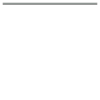

In [18]:
b0 = box(-1.75, -5e-3, 1.75, 5e-3)
b0

`bb0`: 3 m long, a shorter template for the triangular setups

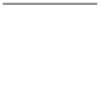

In [19]:
bb0 = box(-1.5, -5e-3, 1.5, 5e-3)
bb0

## Pad 1

### Load DEM

In [20]:
ds1 = rasterio.open(dataloc / 'pad1_1.276mm_dem.geo.tif')
ds1a = rasterio.open(dataloc / 'pad1_1.276mm_hillshade.tif')

Spacial resolution (in x- and y directions):

In [21]:
ds1.res

(0.00127582096821174, 0.0012758209682117404)

In [22]:
dem1 = ds1.read(1, masked=True)
dem1.dtype

dtype('float64')

#### Boundary for searches

Rows and columns of corners given by boundaries

In [23]:
b1xmn, b1xmx = 14.5, 18
b1ymn, b1ymx = 50.5, 52.5

#### Crater Minimum

Find minimum within the boundaries and it's indexes -> location

In [24]:
get_crater_min(ds1, ((14.5, 52.5), (18., 50.5)))

{'rc': (2471, 4374), 'xy': array([16.52917306, 51.39691638])}

#### Corner blocks

In [25]:
ref = np.array([
    [14.975, 52.357, -1.368], [18.159, 52.183, -1.337],
    [14.714, 50.882, -1.341], [17.868, 50.276, -1.319]
])

#### Charge Locations

In [26]:
cc1 = np.loadtxt(dataloc / 'Pad1/charge-coords_v.a.csv',
                 delimiter=',', skiprows=1)
cc1

array([[15.481  , 51.474  , -1.74125],
       [16.096  , 51.427  , -1.74125],
       [16.712  , 51.357  , -1.74125],
       [15.481  , 51.474  , -2.04125],
       [16.096  , 51.427  , -2.04125],
       [16.712  , 51.357  , -2.04125]])

In [27]:
x01, y01, z01 = cc1[1, :]

(50.0, 53.0)

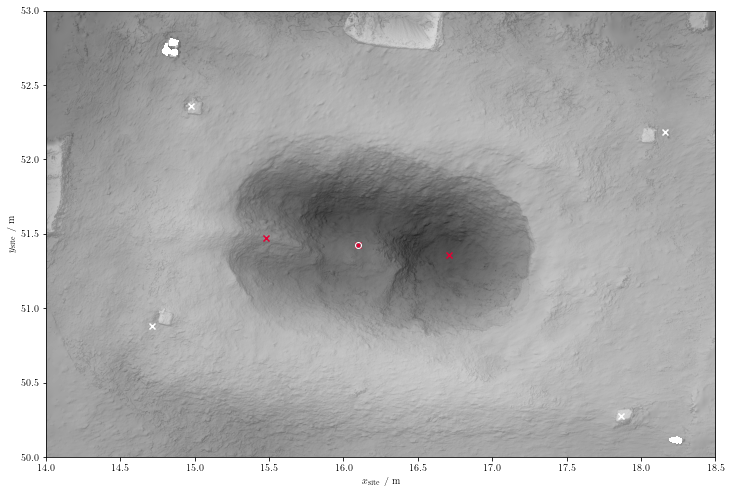

In [28]:
fig, ax = plt.subplots()
show_dem(ax=ax, ds=ds1a, ref=ref, cc=cc1, org=cc1[1, :2])
ax.set_xlim(14, 18.5); ax.set_ylim(50, 53)

In [29]:
d = dem_to_cratercoords(ds1a, cc=cc1[:3, :2], setup='line',
                        width=3.5, height=2., ret='all')
ds1b = rasterio.open(d['fname'], mode='r')

In [30]:
stub = ds1.files[0][:-8]
for end in ['.geo.tif', '.tif']:
    ds = rasterio.open(stub + end, mode='r')
    dem_to_cratercoords(ds, cc=cc1[:3, :2], setup='line', width=3.5, height=2.)
convert_to_jpeg(stub + '_ccoords.tif')
convert_to_jpeg(stub[:-3] + 'hillshade_ccoords.tif')

In [31]:
cc1cco = site_to_cratercoords(cc1[:3, :2], cc1[1, :2], d['phi'])
cc1cco

array([[-0.61668794, -0.0114011 ],
       [ 0.        ,  0.        ],
       [ 0.61985967, -0.0114011 ]])

### Profiles along charges

Angle of charge lines relavtive to coordinate system

In [32]:
x1, x2 = cc1[[0, 2], 0]
y1, y2 = cc1[[0, 2], 1]
ϕ = np.arctan((y2 - y1) / (x2 - x1)) * 180 / np.pi
ϕ 

-5.4293495163779415

Take box template `b0`, translate it to $(x_0, y_0)$, and rotate it to be parallel to charge line

In [33]:
b = rotate(translate(b0, x01, y01), ϕ)
b.exterior.xy

(array('d', [17.837675756603375, 17.838621939336164, 14.354324243396631, 14.353378060663834, 17.837675756603375]),
 array('d', [51.25644045362374, 51.266395589897854, 51.59755954637626, 51.587604410102145, 51.25644045362374]))

Helper line to shift profile in the crater's coordinate system

In [34]:
c1min = get_crater_min(ds1, ((14.5, 52.5), (18, 50.5)))
c1min

{'rc': (2471, 4374), 'xy': array([16.52917306, 51.39691638])}

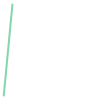

In [35]:
ort = orth_to_slice(b)
ort

In [36]:
x2, y2 = ort.interpolate(0.5 * ort.length - 0.2, normalized=False).xy
x2, y2 = x2[0], y2[0]
x2, y2

(16.114923654655904, 51.62610272548226)

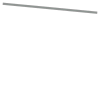

In [37]:
b2 = rotate(translate(b0, x2, y2), ϕ)
b2

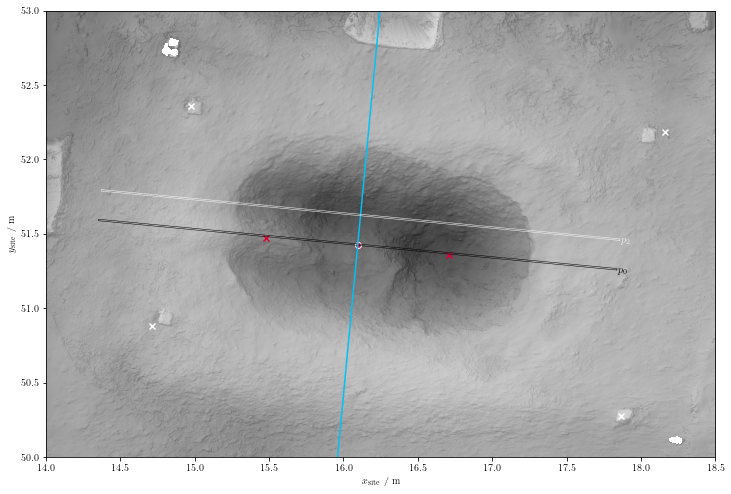

In [38]:
add_profs_to_dem(ax, b, b2, ort)
fig

#### Make the Profiles

Three steps:
- Select minimal rectangular region that contains all pixels values inside `box`
- Get all indeces that are not masked
- Get (x, y) coordinates assiciated with unmasked indices

for `b`, profile that contains the charge positions

In [39]:
p10, trnf = mask.mask(ds1, [b], crop=True, filled=False,
                      nodata=np.nan, indexes=1)
idxy10 = get_not_masked(p10)
xy10 = get_xy(idxy10, trnf)

for `b2`, profile shifted 20 cm 'back', which is somewhat deeper

In [40]:
p12, tr2 = mask.mask(ds1, [b2], crop=True, filled=False,
                     nodata=np.nan, indexes=1)
idxy12 = get_not_masked(p12)
xy12 = get_xy(idxy12, tr2)

Calculate position along blast charge line, relative to center charge position $(x_0, y_0)$

In [41]:
r10 = site_to_cratercoords(xy10, (x01, y01), ϕ)[:, 0]
r12 = site_to_cratercoords(xy12, (x01, y01), ϕ)[:, 0]

Charge locations in crater coordinates

In [42]:
cr1 = site_to_cratercoords(cc1[:, :2], (x01, y01), ϕ)[:, 0]
cz1 = cc1[:, 2] - (z01 + 0.3)
cr1, cz1

(array([-0.60779382,  0.        ,  0.60661312, -0.60779382,  0.        ,
         0.60661312]),
 array([-0.3, -0.3, -0.3, -0.6, -0.6, -0.6]))

In [43]:
ds1c = rasterio

In [44]:
cc1[:, :2]

array([[15.481, 51.474],
       [16.096, 51.427],
       [16.712, 51.357],
       [15.481, 51.474],
       [16.096, 51.427],
       [16.712, 51.357]])

In [45]:
cmin1cc = site_to_cratercoords(c1min['xy'][None, :], (x01, y01), ϕ)[0]
cmin1cc

array([ 0.42838323, -0.07093474])

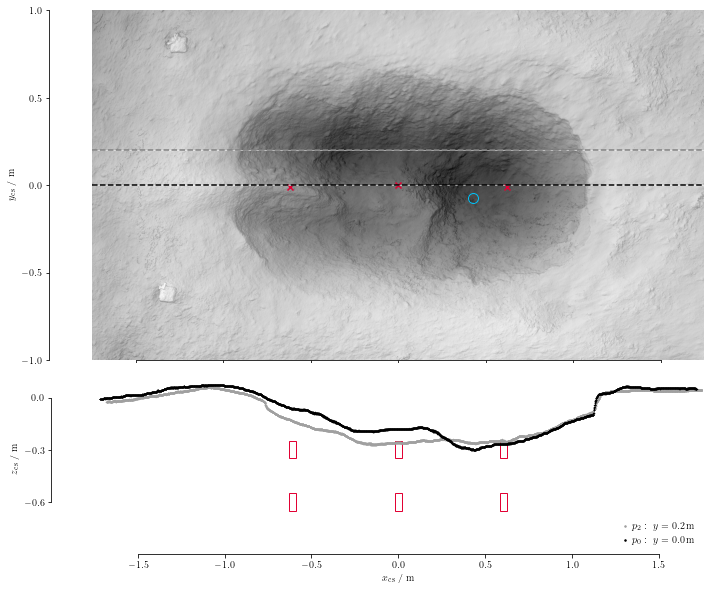

In [46]:
fig = plt.figure()
ax1 = plt.subplot2grid((31, 1), (0, 0), rowspan=20, colspan=1, fig=fig)
ax2 = plt.subplot2grid((31, 1), (20, 0), rowspan=11, colspan=1,
                       fig=fig, sharex=ax1)

plot_crater_cs(ax1, ds1b, cc1cco, xbounds=(-1.75, 1.75), xlim=(-1.75, 1.75),
               lspineloc=-2)
profileplot(ax2,
    x1=r10, z1=p10[idxy10[:, 1], idxy10[:, 0]] - (z01 + 0.3),
    x2=r12, z2=p12[idxy12[:, 1], idxy12[:, 0]] - (z01 + 0.3),
    chargecoords=(cr1, cz1),
    lbl=(r'$p_0:\ y=0.0\,\mathrm{m}$', r'$p_2:\ y=0.2\,\mathrm{m}$'),
    xlim=(-1.75, 1.75), lspineloc=-2
)
ax1.plot(*cmin1cc, 'o', ms=10, mfc='none', mec=clr.hlp1)
ax1.set_yticks([-1, -.5, 0, .5, 1]);

# fig

## Pad2

### Load DEM

In [47]:
ds2 = rasterio.open(dataloc / 'pad2_1.214mm_dem.geo.tif')
ds2a = rasterio.open(dataloc / 'pad2_1.214mm_hillshade.tif')
ds2.res

(0.001213758985, 0.001213758985)

In [48]:
dem2 = ds2.read(1, masked=True)
dem2.dtype

dtype('float32')

#### Corner blocks

In [49]:
ref = np.array([
    [17.840, 52.305, -1.340], [21.702, 51.614, 1.332],
    [17.841, 50.291, -1.319], [21.435, 50.068, 1.303]
])

#### Charge Coordinates

In [50]:
cc2 = np.loadtxt(dataloc / 'Pad2/charge-coords.csv',
                 delimiter=',', skiprows=1, usecols=[1, 2, 3])
cc2

array([[19.1  , 51.213, -1.72 ],
       [19.718, 51.157, -1.72 ],
       [20.349, 51.083, -1.72 ],
       [19.1  , 51.213, -2.02 ],
       [19.718, 51.157, -2.02 ],
       [20.349, 51.083, -2.02 ]])

In [51]:
x02, y02, z02 = cc2[1, :]

(49.5, 52.5)

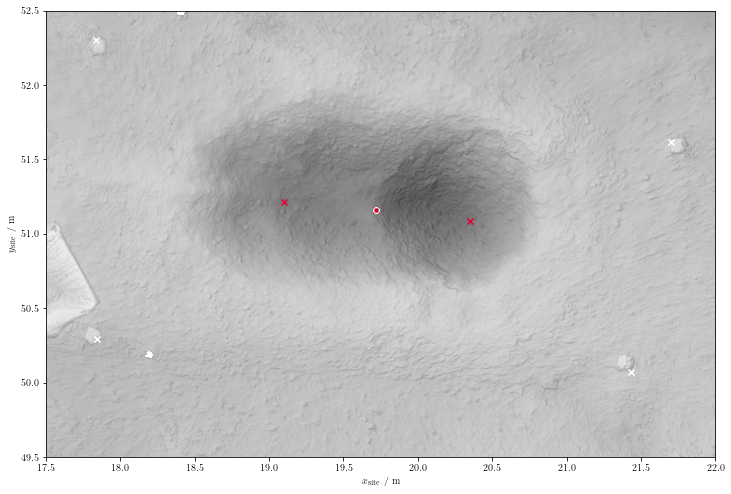

In [52]:
fig, ax = plt.subplots()
show_dem(ax, ds2a, ref, cc2, org=cc2[1, :2])
ax.set_xlim(17.5, 22); ax.set_ylim(49.5, 52.5)

In [53]:
d = dem_to_cratercoords(ds2a, cc=cc2[:3, :2], setup='line',
                        width=3.5, height=2., ret='all')
ds2b = rasterio.open(d['fname'], mode='r')

In [54]:
stub = ds2.files[0][:-8]
for end in ['.geo.tif', '.tif']:
    ds = rasterio.open(stub + end, mode='r')
    dem_to_cratercoords(ds, cc=cc2[:3, :2], setup='line', width=3.5, height=2.)
convert_to_jpeg(stub + '_ccoords.tif')
convert_to_jpeg(stub[:-3] + 'hillshade_ccoords.tif')

In [55]:
cc2cco = site_to_cratercoords(cc2[:3, :2], cc2[1, :2], d['phi'])
cc2cco

array([[-0.6204768 , -0.00827874],
       [ 0.        ,  0.        ],
       [ 0.63527039, -0.00827874]])

### Profiles along charges

Angle of charges relative to coordinate system

In [56]:
x1, x2 = cc2[[0, 2], 0]
y1, y2 = cc2[[0, 2], 1]
ϕ = np.arctan((y2 - y1) / (x2 - x1)) * 180 / np.pi
ϕ 

-5.942135835450877

Take box template `b0`, translate it to $(x_0, y_0)$, and rotate it to be parallel to charge line

In [57]:
b = rotate(translate(b0, x02, y02), ϕ)

Helper line to shift profile in the crater coordinate system

In [58]:
c2min = get_crater_min(ds2, ((18, 52.), (21., 50.)))
c2min

{'rc': (3881, 3852), 'xy': array([20.09672817, 51.19888239])}

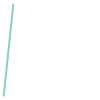

In [59]:
ort = orth_to_slice(b)
ort

In [60]:
x2, y2 = ort.interpolate(0.5 * ort.length - 0.2, normalized=False).xy
x2, y2 = x2[0], y2[0]
x2, y2

(19.738704804478054, 51.35592539071603)

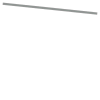

In [61]:
b2 = rotate(translate(b0, x2, y2), ϕ)
b2

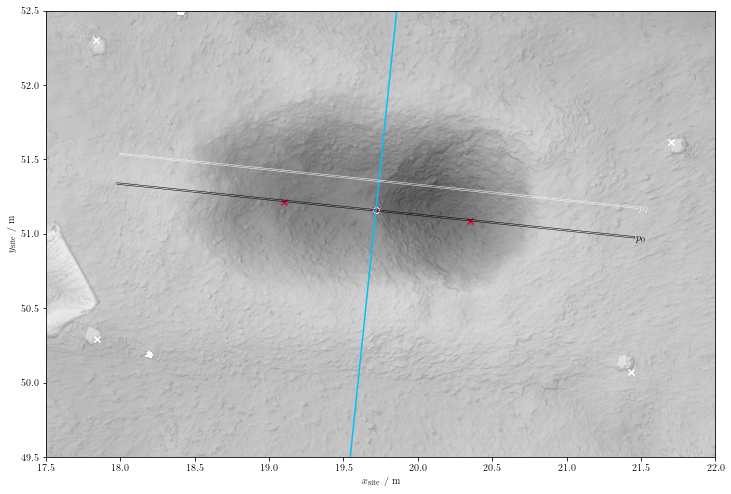

In [62]:
add_profs_to_dem(ax, b, b2, ort)
fig

### Make the Profiles

Three steps:
- Select minimal rectangular region that contains all pixels values inside `box`
- Get all indeces that are not masked
- Get (x, y) coordinates assiciated with unmasked indices

for `b`, profile that contains all charge positions

In [63]:
p20, trnf = mask.mask(ds2, [b], crop=True, filled=False,
                      nodata=np.nan, indexes=1)
idxy20 = get_not_masked(p20)
xy20 = get_xy(idxy20, trnf)

for `b2`, profile that is shifted 20 cm 'back'. Similar to pad 1, but the differences to the center line are less pronounced.

In [64]:
p22, tr2 = mask.mask(ds2, [b2], crop=True, filled=False,
                    nodata=np.nan, indexes=1)
idxy22 = get_not_masked(p22)
xy22 = get_xy(idxy22, tr2)

Calculate position along blast charge line, relative to center charge position $(x_0, y_0)$

In [65]:
r20 = site_to_cratercoords(xy20, (x02, y02), ϕ)[:, 0]
r22 = site_to_cratercoords(xy22, (x02, y02), ϕ)[:, 0]

Charge locations in crater coordinates

In [66]:
cr2 = site_to_cratercoords(cc2[:, :2], (x02, y02), ϕ)[:, 0]
cz2 = cc2[:, 2] - (z02 + 0.3)
cr2, cz2

(array([-0.60888211,  0.        ,  0.61994883, -0.60888211,  0.        ,
         0.61994883]),
 array([-0.3, -0.3, -0.3, -0.6, -0.6, -0.6]))

In [67]:
r20[[0, -1]]

array([-1.7113139 ,  1.71030427])

In [68]:
cmin2cc = site_to_cratercoords(c2min['xy'][None,], (x02, y02), ϕ)[0]
cmin2cc

array([0.38102908, 0.00244989])

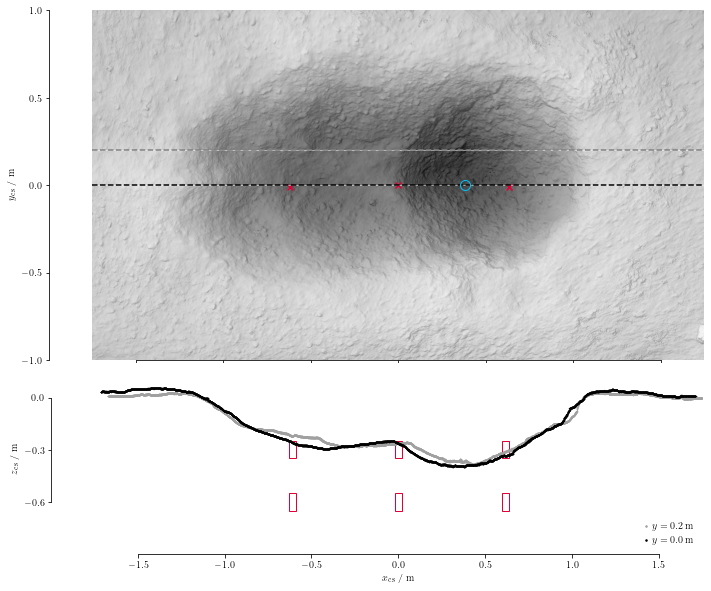

In [69]:
fig = plt.figure()
ax1 = plt.subplot2grid((31, 1), (0, 0), rowspan=20, colspan=1, fig=fig)
ax2 = plt.subplot2grid((31, 1), (20, 0), rowspan=11, colspan=1, fig=fig,
                       sharex=ax1)

plot_crater_cs(ax1, ds2b, cc2cco, xbounds=(-1.75, 1.75), lspineloc=-2)

profileplot(ax2,
    x1=r20, z1=p20[idxy20[:, 1], idxy20[:, 0]] - (z02 + 0.3),
    x2=r22, z2=p22[idxy22[:, 1], idxy22[:, 0]] - (z02 + 0.3),
    chargecoords=(cr2, cz2),
    lbl=(r'$y=0.0\,\mathrm{m}$', r'$y=0.2\,\mathrm{m}$'),
    lspineloc=-2
)
ax1.plot(*cmin2cc, 'o', ms=10, mfc='none', mec=clr.hlp1)
ax1.set_yticks([-1, -.5, 0, .5, 1]);

# fig

## Pad 3

### Load DEM

In [70]:
ds3 = rasterio.open(dataloc / 'pad3_1.425mm_dem.geo.tif')
ds3a = rasterio.open(dataloc / 'pad3_1.425mm_hillshade.tif')
ds3.res

(0.0014250000000000003, 0.0014250000000000003)

In [71]:
dem3 = ds3.read(1, masked=True)
dem3.dtype

dtype('float32')

### Corner blocks

In [72]:
ref = np.array([
    [22.221, 51.440, -1.331], [24.885, 51.581, -1.363],
    [21.978, 49.465, -1.295], [24.542, 48.569, -1.250]
])

### Charge Locations

In [73]:
cc3 = np.loadtxt(dataloc / 'Pad3/charge-coords_site-crs.csv',
                 delimiter=',', skiprows=1)
cc3

array([[22.874  , 50.027  , -1.70975],
       [23.183  , 50.533  , -1.70975],
       [23.493  , 50.002  , -1.70975],
       [22.874  , 50.027  , -2.00975],
       [23.183  , 50.533  , -2.00975],
       [23.493  , 50.002  , -2.00975]])

Set the origin of the crater coordinate system to the centroid of the charges

In [74]:
center3 = cc3[:3, :3].sum(axis=0) / 3
x03, y03, z03 = center3

(48.3, 51.8)

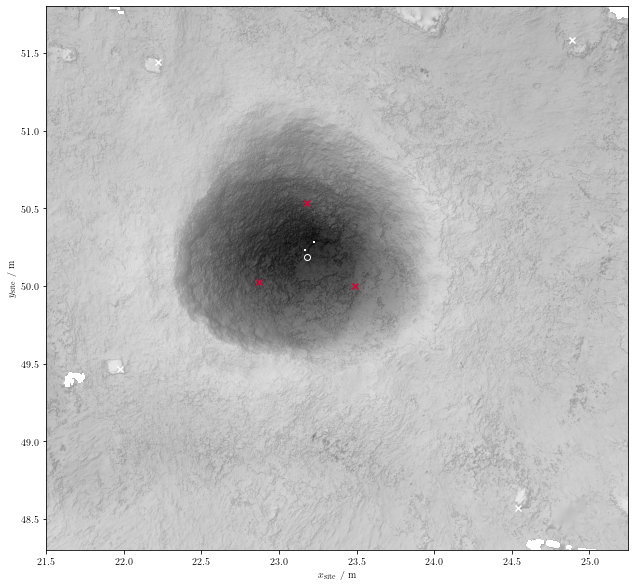

In [75]:
fig, ax = plt.subplots()
show_dem(ax, ds3a, ref, cc3, org=center3)
ax.set_xlim(21.5, 25.25); ax.set_ylim(48.3, 51.8)

In [76]:
d = dem_to_cratercoords(ds3a, cc=cc3[:3, :2], setup='triag',
                        width=3., height=2.5, ret='all')
ds3b = rasterio.open(d['fname'], mode='r')

In [77]:
d

{'center': array([23.18333333, 50.18733333]),
 'phi': 2.312789052955678,
 'fname': '../data/UMKC/pad3_1.425mm_hillshade_ccoords.tif',
 'transform': Affine(0.0014250000000000003, 0.0, -1.5,
        0.0, -0.0014250000000000003, 1.25)}

In [78]:
72 / 1.8

40.0

In [79]:
stub = ds3.files[0][:-8]
for end in ['.geo.tif', '.tif']:
    ds = rasterio.open(stub + end, mode='r')
    dem_to_cratercoords(ds, cc=cc3[:3, :2], setup='triag', width=3., height=2.5)
convert_to_jpeg(stub + '_ccoords.tif')
convert_to_jpeg(stub[:-3] + 'hillshade_ccoords.tif')

In [80]:
cc3cco = site_to_cratercoords(cc3[:3, :2], d['center'], d['phi'])
cc3cco

array([[-0.30261113, -0.17268582],
       [-0.01428238,  0.34537164],
       [ 0.31689351, -0.17268582]])

### Profiles along charges

One profile will cross the crater center (charge centroid), the other will pass through two of the lateral charge locations

Angle of crater coordinates system relative to site system

In [81]:
x1, x2 = cc3[[0, 2], 0]
y1, y2 = cc3[[0, 2], 1]
ϕ = np.arctan((y2 - y1) / (x2 - x1)) * 180 / np.pi
ϕ 

-2.312789052955678

Take box template `b0`, translate it to $(x_0, y_0)$, and rotate it to be parallel to charge line

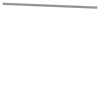

In [82]:
b = rotate(translate(bb0, x03, y03), ϕ)
b

In [83]:
c3min = get_crater_min(ds3, ((22.5, 50.6), (24, 49.5)))
c3min

{'rc': (4276, 4607), 'xy': array([23.24708647, 50.28285396])}

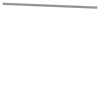

In [84]:
b1 = rotate(translate(bb0, *c3min['xy']), ϕ)
b1

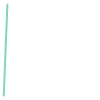

In [85]:
ort = orth_to_slice(b)
ort

In [86]:
d3 = np.sqrt((x1 - x03) ** 2 + (y1 - y03) ** 2)
d3

0.3484162580719935

In [87]:
xb, yb = .5 * (x1 + x2), .5 * (y1 + y2)
xb, yb

(23.183500000000002, 50.0145)

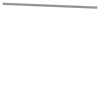

In [88]:
b2 = rotate(translate(bb0, xb, yb), ϕ)
b2

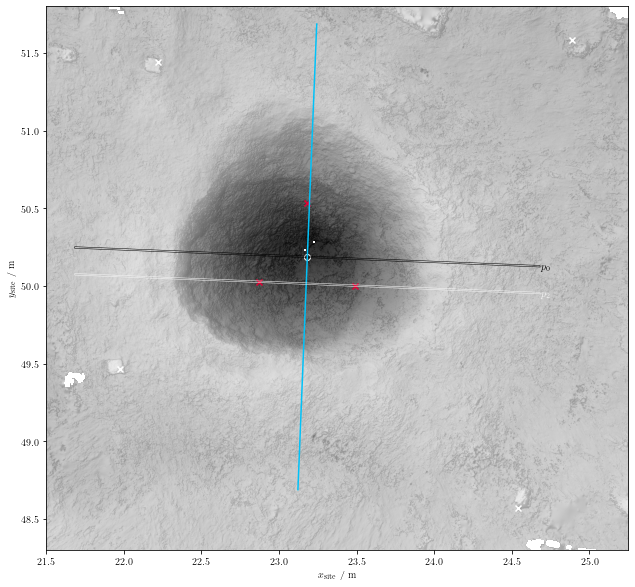

In [89]:
add_profs_to_dem(ax, b, b2, ort)
fig

### Make the Profiles

Three steps:
- Select minimal rectangular region that contains all pixels values inside `box`
- Get all indexes that are not masked
- Get (x, y) coordinates associated with unmasked indices

for box `b`, profile through two of the lateral charge locations

In [90]:
p30, trnf = mask.mask(ds3, [b], crop=True, filled=False,
                      nodata=np.nan, indexes=1)
idxy30 = get_not_masked(p30)
xy30 = get_xy(idxy30, trnf)

for `b1`, profile through the crater system's origin

In [91]:
p31, tr1 = mask.mask(ds3, [b1], crop=True, filled=False,
                     nodata=np.nan, indexes=1)
idxy31 = get_not_masked(p31)
xy31 = get_xy(idxy31, tr1)

for `b2`, profile through the crater system's origin

In [92]:
p32, tr2 = mask.mask(ds3, [b2], crop=True, filled=False,
                     nodata=np.nan, indexes=1)
idxy32 = get_not_masked(p32)
xy32 = get_xy(idxy32, tr2)

Calculate position along blast charge line, relative to center charge position $(x_0, y_0)$

In [93]:
r30 = site_to_cratercoords(xy30, (x03, y03), ϕ)[:, 0]
r31 = site_to_cratercoords(xy31, (x03, y03), ϕ)[:, 0]
r32 = site_to_cratercoords(xy32, (x03, y03), ϕ)[:, 0]

Charge locations in crater coordinates

In [94]:
cr3 = site_to_cratercoords(cc3[:, :2], (x03, y03), -ϕ)[:, 0]
cz3 = cc3[:, 2] - (z03 + 0.3)
cr3, cz3

(array([-0.30261113, -0.01428238,  0.31689351, -0.30261113, -0.01428238,
         0.31689351]),
 array([-0.3, -0.3, -0.3, -0.6, -0.6, -0.6]))

In [95]:
r30[[0, -1]]

array([-1.49492015,  1.49281437])

In [96]:
cmin3cc = site_to_cratercoords(c3min['xy'][None,], (x03, y03), ϕ)[0]
cmin3cc

array([0.06755592, 0.09287007])

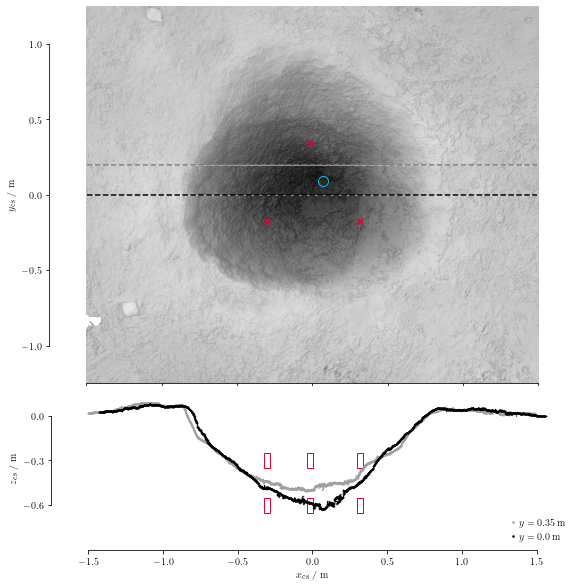

In [97]:
fig = plt.figure()
ax1 = plt.subplot2grid((36, 1), (0, 0), rowspan=25, colspan=1, fig=fig)
ax2 = plt.subplot2grid((36, 1), (25, 0), rowspan=11, colspan=1, fig=fig)

plot_crater_cs(ax1, ds3b, cc3cco, xbounds=r30[[0, -1]], xlim=(-1.75, 1.75))

profileplot(ax2,
    x1=r31, z1=p31[idxy31[:, 1], idxy31[:, 0]] - (z03 + 0.3),
    x2=r32, z2=p32[idxy32[:, 1], idxy32[:, 0]] - (z03 + 0.3),
    chargecoords=(cr3, cz3),
    lbl=(r'$y=0.0\,\mathrm{m}$', r'$y=%.2f\,\mathrm{m}$' % d3),
    xlim=(-1.75, 1.75)
)

ax1.plot(*cmin3cc, 'o', ms=10, mfc='none', mec=clr.hlp1)

# fig

## Pad 4

### Load DEM

In [98]:
ds4 = rasterio.open(dataloc / 'pad4_2.512mm_dem.3.geo.tif')
ds4a = rasterio.open(dataloc / 'pad4_2.512mm_hillshade.3.tif')
ds4.res

(0.00251191894725, 0.00251191894725)

In [99]:
dem4 = ds4.read(1, masked=True)
dem4.dtype

dtype('float32')

Mask things outside region of interest to make things a little faster

In [100]:
ds4.index(24, 52), ds4.index(28, 48)

((2269, 2621), (3861, 4214))

In [101]:
dem4.mask[:, :2621] = True
dem4.mask[:2269, :] = True
dem4.mask[:, 4214:] = True
dem4.mask[3861:, :] = True

In [102]:
dem4.data[dem4.mask] = np.nan
dem4.mask = np.isnan(dem4.data)

#### Corner blocks

These are the 'shifted' coordinates that are compatible with the charge coordinates.
The measured block positions of pad 4 had to be adjusted; see the {doc}`crater_dem_hillshade.ipnb` notebook.

In [103]:
ref = np.array([
    [25.022, 51.600], [27.605, 50.720],
    [24.370, 48.705], [27.287, 48.805]]
)

#### Charge Locations

In [104]:
cc4 = np.loadtxt(dataloc / 'Pad4/charge-coords_site-crs.csv',
                 delimiter=',', skiprows=1)
cc4

array([[25.988 , 49.668 , -1.7155],
       [26.317 , 50.168 , -1.7155],
       [26.581 , 49.628 , -1.7155],
       [25.988 , 49.668 , -2.0155],
       [26.317 , 50.168 , -2.0155],
       [26.581 , 49.628 , -2.0155]])

Set the crater coordinate system's origin to the charges centroid.

(There is some blurr around the absolute elevation of the pad 4 DEM.)

In [105]:
center4 = cc4[:3, :3].sum(axis=0) / 3
x04, y04, z04 = center4
z04 += .045
x04, y04, z04

(26.295333333333332, 49.821333333333335, -1.6705000000000003)

(48.0, 52.0)

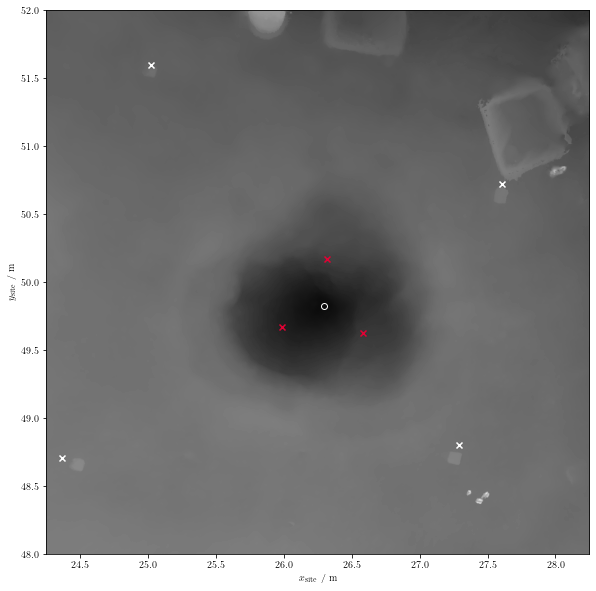

In [106]:
fig, ax = plt.subplots()

show_dem(ax, ds4, ref, cc4, org=(x04, y04))
ax.set_xlim(24.25, 28.25); ax.set_ylim(48, 52)

In [107]:
cc4[:3, :2]

array([[25.988, 49.668],
       [26.317, 50.168],
       [26.581, 49.628]])

In [108]:
print(dem_to_cratercoords(
    rasterio.open(dataloc / 'pad4_2.512mm_dem.3.tif'),
    cc=cc4[:3, :2], setup='triag', width=3., height=2.5, ret='all'))
d = dem_to_cratercoords(ds4a, cc=cc4[:3, :2], setup='triag',
                        width=3., height=2.5, ret='all')
ds4b = rasterio.open(d['fname'], mode='r')

{'center': array([26.29533333, 49.82133333]), 'phi': 3.8589623971930775, 'fname': '../data/UMKC/pad4_2.512mm_dem.3_ccoords.tif', 'transform': Affine(0.00251191894725, 0.0, -1.5,
       0.0, -0.00251191894725, 1.25)}


In [109]:
stub = ds4.files[0][:-8]
dem_to_cratercoords(ds4, cc=cc4[:3, :2], setup='triag', width=3., height=2.5)
convert_to_jpeg(stub + '_ccoords.tif')
convert_to_jpeg(stub[:-5] + 'hillshade.3_ccoords.tif')

In [110]:
cc4cco = site_to_cratercoords(cc4[:3, :2], d['center'], d['phi'])
cc4cco

array([[-0.29631709, -0.17366943],
       [-0.00171336,  0.34733886],
       [ 0.29803045, -0.17366943]])

### Profiles along charges

In [111]:
cx3, cx2 = cc4[[0, 2], 0]
cy3, cy2 = cc4[[0, 2], 1]
ϕ = np.arctan((cy2 - cy3) / (cx2 - cx3)) * 180 / np.pi
ϕ 

-3.8589623971930775

Take box template `b0`, translate it to $(x_0, y_0)$, and rotate it to be parallel to charge line

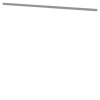

In [112]:
b = translate(rotate(bb0, ϕ), x04, y04)
b

In [113]:
c4min = get_crater_min(ds4, ((22.3, 50.7), (27, 49.25)))
c4min

{'rc': (3136, 3535), 'xy': array([26.29533333, 49.82133333])}

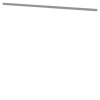

In [114]:
b1 = rotate(translate(bb0, *c4min['xy']), ϕ)
b1

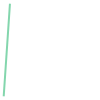

In [115]:
ort = orth_to_slice(b)
ort

In [116]:
xb, yb = .5 * (cx2 + cx3), .5 * (cy2 + cy3)

In [117]:
d4 = np.sqrt((xb - x04) ** 2 + (yb - y04) ** 2)
d4

0.17367154503705406

In [118]:
x2, y2 = ort.interpolate(0.5 * ort.length - d4, normalized=False).xy
x2, y2 = x2[0], y2[0]
x2, y2

(26.30702154825353, 49.99461111952515)

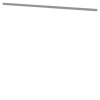

In [119]:
b2 = rotate(translate(bb0, xb, yb), ϕ)
b2

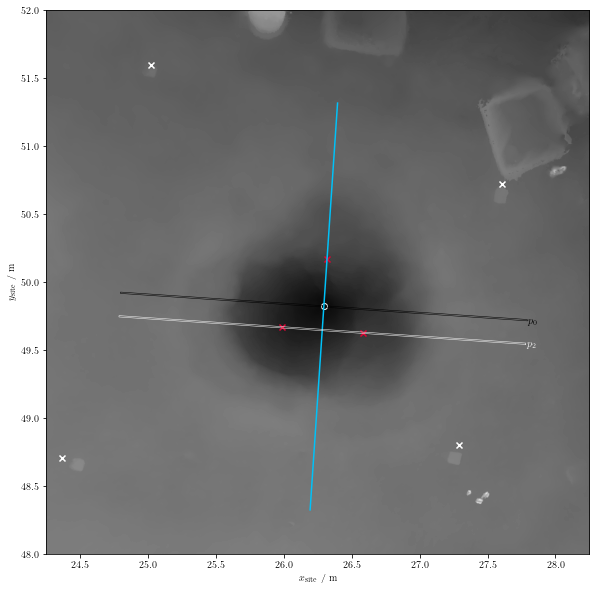

In [120]:
add_profs_to_dem(ax, b, b2, ort)
fig

### Make the Profiles

Three steps:
- Select minimal rectangular region that contains all pixels values inside `box`
- Get all indeces that are not masked
- Get (x, y) coordinates assiciated with unmasked indices

for `b`, similar to pad 3

In [121]:
p40, trnf = mask.mask(ds4, [b], crop=True, filled=False,
                      nodata=np.nan, indexes=1)
idxy40 = get_not_masked(p40)
xy40 = get_xy(idxy40, trnf)

for `b1`, profile through the crater system's origin

In [122]:
p41, tr1 = mask.mask(ds4, [b1], crop=True, filled=False,
                     nodata=np.nan, indexes=1)
idxy41 = get_not_masked(p41)
xy41 = get_xy(idxy41, tr1)

for `b2`

In [123]:
p42, tr2 = mask.mask(ds4, [b2], crop=True, filled=False,
                     nodata=np.nan, indexes=1)
idxy42 = get_not_masked(p42)
xy42 = get_xy(idxy42, tr2)

Calculate position along blast charge line, relative to center charge position $(x_0, y_0)$

In [124]:
xy40[:5]

array([[24.7994856 , 49.92808989],
       [24.80199752, 49.92808989],
       [24.7994856 , 49.92557797],
       [24.80199752, 49.92557797],
       [24.80450944, 49.92557797]])

In [125]:
xy41[:5]

array([[24.7994856 , 49.92808989],
       [24.80199752, 49.92808989],
       [24.7994856 , 49.92557797],
       [24.80199752, 49.92557797],
       [24.80450944, 49.92557797]])

In [126]:
r40 = site_to_cratercoords(xy40, (x04, y04), ϕ)[:, 0]
r41 = site_to_cratercoords(xy41, (x04, y04), ϕ)[:, 0]
r42 = site_to_cratercoords(xy42, (x04, y04), ϕ)[:, 0]

In [127]:
cr4 = site_to_cratercoords(cc4[:, :2], (x04, y04), -ϕ)[:, 0]
cz4 = cc4[:, 2] - (z04 + 0.3) + .045
cr4, cz4

(array([-0.29631709, -0.00171336,  0.29803045, -0.29631709, -0.00171336,
         0.29803045]),
 array([-0.3, -0.3, -0.3, -0.6, -0.6, -0.6]))

In [128]:
cc4[:, 1].mean()

49.821333333333335

In [129]:
cc4[:, 0].mean()

26.295333333333332

In [130]:
c4min['xy']

array([26.29533333, 49.82133333])

In [131]:
cmin4cc = site_to_cratercoords(c4min['xy'][None,], (x04, y04), ϕ)[0]
cmin4cc

array([0., 0.])

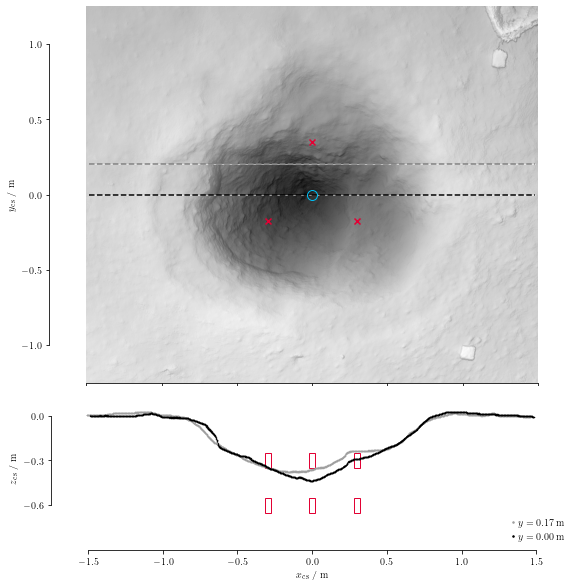

In [132]:
fig = plt.figure()
ax1 = plt.subplot2grid((36, 1), (0, 0), rowspan=25, colspan=1, fig=fig)
ax2 = plt.subplot2grid((36, 1), (25, 0), rowspan=11, colspan=1, fig=fig,
                       sharex=ax1)

plot_crater_cs(ax1, ds4b, cc4cco, xbounds=r40[[0, -1]], xlim=(-1.75, 1.75))

profileplot(ax2,
    x1=r41, z1=p41[idxy41[:, 1], idxy41[:, 0]] - (z04 + 0.3),
    x2=r42, z2=p42[idxy42[:, 1], idxy42[:, 0]] - (z04 + 0.3),
    chargecoords=(cr4, cz4),
    lbl=(r'$y=%.2f\,\mathrm{m}$' % (c4min['xy'][1] - cc4[:, 1].mean()),
         r'$y=%.2f\,\mathrm{m}$' % d4),
    xlim=(-1.75, 1.75)
)

ax1.plot(*cmin4cc, 'o', ms=10, mfc='none', mec=clr.hlp1)

## Summary

### All Pads: Hillshades + Profiles

In [133]:
%%capture
fig = plt.figure(constrained_layout=True)
axd = fig.subplot_mosaic([
    ['m1', 'm2'],
    ['p1', 'p2'],
    ['.', '.'],
    ['m3', 'm4'],
    ['p3', 'p4']],
    gridspec_kw={'height_ratios': [40, 22, 10, 50, 22], 'wspace': .1}
)
ax1, ax2, ax3, ax4 = axd['m1'], axd['p1'], axd['m2'], axd['p2']
ax5, ax6, ax7, ax8 = axd['m3'], axd['p3'], axd['m4'], axd['p4']

In [134]:
plot_crater_cs(ax1, ds1b, cc1cco, xbounds=(-1.75, 1.75), lspineloc=-2)
ax1.plot(*cmin1cc, 'o', ms=10, mfc='none', mec=clr.hlp1)
profileplot(ax2,
    x1=r10, z1=p10[idxy10[:, 1], idxy10[:, 0]] - (z01 + 0.3),
    x2=r12, z2=p12[idxy12[:, 1], idxy12[:, 0]] - (z02 + 0.3),
    chargecoords=(cr1, cz1), xlim=(-1.75, 1.75), lspineloc=-2,
    lbl=(r'$y=0.0\,\mathrm{m}$', r'$y=0.2\,\mathrm{m}$')
)

In [135]:
plot_crater_cs(ax3, ds2b, cc2cco, xbounds=(-1.75, 1.75), lspineloc=-2)
ax3.plot(*cmin2cc, 'o', ms=10, mfc='none', mec=clr.hlp1)
profileplot(ax4,
    x1=r20, z1=p20[idxy20[:, 1], idxy20[:, 0]] - (z02 + 0.3),
    x2=r22, z2=p22[idxy22[:, 1], idxy22[:, 0]] - (z02 + 0.3),
    chargecoords=(cr2, cz2), xlim=(-1.75, 1.75), lspineloc=-2,
    lbl=(r'$y=0.0\,\mathrm{m}$', r'$y=0.2\,\mathrm{m}$')
)

In [136]:
plot_crater_cs(ax5, ds3b, cc3cco, xbounds=r30[[0, -1]], xlim=(-1.75, 1.75))
ax5.plot(*cmin3cc, 'o', ms=10, mfc='none', mec=clr.hlp1)
profileplot(ax6,
    x1=r31, z1=p31[idxy31[:, 1], idxy31[:, 0]] - (z03 + 0.3),
    x2=r32, z2=p32[idxy32[:, 1], idxy32[:, 0]] - (z03 + 0.3),
    chargecoords=(cr3, cz3),
    lbl=(r'$y=0.0\,\mathrm{m}$', r'$y=%.2f\,\mathrm{m}$' % d3)
)

In [137]:
plot_crater_cs(ax7, ds4b, cc4cco, xbounds=r40[[0, -1]], xlim=(-1.75, 1.75))
ax7.plot(*cmin4cc, 'o', ms=10, mfc='none', mec=clr.hlp1)
profileplot(ax8,
    x1=r41, z1=p41[idxy41[:, 1], idxy41[:, 0]] - (z04 + 0.3),
    x2=r42, z2=p42[idxy42[:, 1], idxy42[:, 0]] - (z04 + 0.3),
    chargecoords=(cr4, cz4),
    lbl=(r'$y=0.0\,\mathrm{m}$', r'$y=%.2f\,\mathrm{m}$' % d4)
)

In [138]:
%%capture
for t, ax in zip(['Pad 1', 'Pad 2', 'Pad 3', 'Pad 4'],
                 [ax1, ax3, ax5, ax7]):
    ax.set_yticks([-1, -.5, 0, .5, 1])
    ax.set_xticklabels([""] * len(ax.get_xticklabels()))
    ax.set_title(t, fontsize=10)

fig.set_size_inches(10.5, 10)

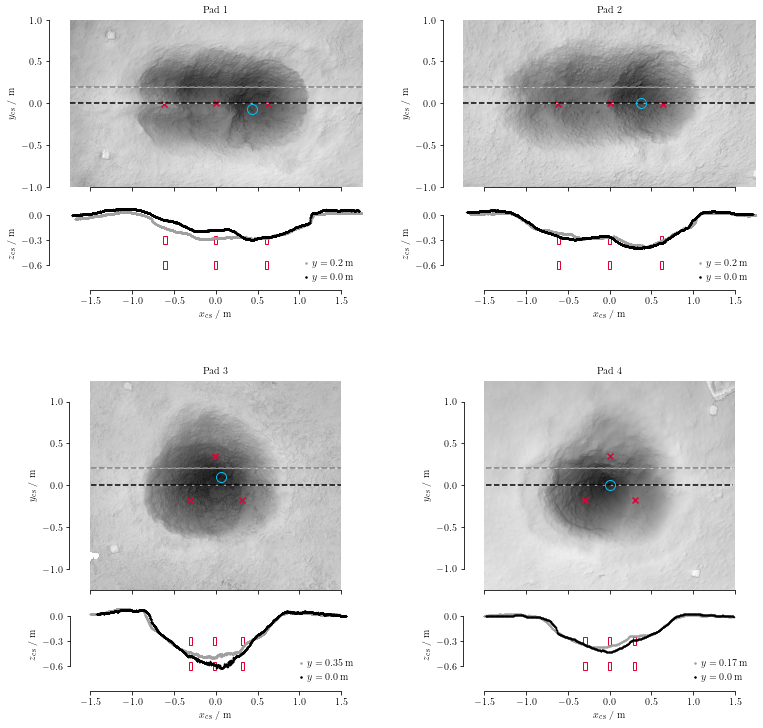

In [139]:
fig

### All Pads: Profiles Only

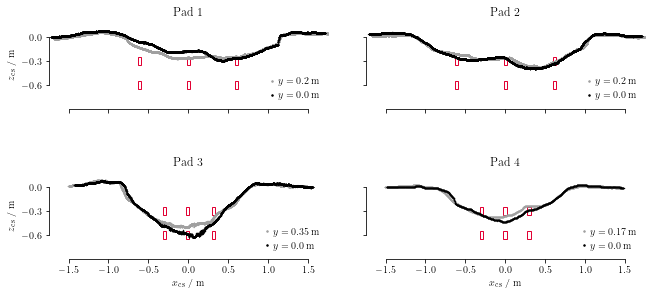

In [140]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

(ax1, ax2), (ax3, ax4) = axs

profileplot(ax1,
    x1=r10, z1=p10[idxy10[:, 1], idxy10[:, 0]] - (z01 + 0.3),
    x2=r12, z2=p12[idxy12[:, 1], idxy12[:, 0]] - (z01 + 0.3),
    chargecoords=(cr1, cz1),
    lbl=(r'$y=0.0\,\mathrm{m}$', r'$y=0.2\,\mathrm{m}$')
)
profileplot(ax2,
    x1=r20, z1=p20[idxy20[:, 1], idxy20[:, 0]] - (z02 + 0.3),
    x2=r22, z2=p22[idxy22[:, 1], idxy22[:, 0]] - (z02 + 0.3),
    chargecoords=(cr2, cz2),
    lbl=(r'$y=0.0\,\mathrm{m}$', r'$y=0.2\,\mathrm{m}$')
)
profileplot(ax3,
    x1=r31, z1=p31[idxy31[:, 1], idxy31[:, 0]] - (z03 + 0.3),
    x2=r32, z2=p32[idxy32[:, 1], idxy32[:, 0]] - (z03 + 0.3),
    chargecoords=(cr3, cz3),
    lbl=(r'$y=0.0\,\mathrm{m}$', r'$y=%.2f\,\mathrm{m}$' % d3)
)
profileplot(ax4,
    x1=r40, z1=p40[idxy40[:, 1], idxy40[:, 0]] - (z04 + 0.3),
    x2=r42, z2=p42[idxy42[:, 1], idxy42[:, 0]] - (z04 + 0.3),
    chargecoords=(cr4, cz4),
    lbl=(r'$y=0.0\,\mathrm{m}$', r'$y=%.2f\,\mathrm{m}$' % d4)
)

for ax in axs[:, 1]:
    ax.set_ylabel('')
for ax in axs[0, :]:
    ax.set_xlabel('')
for i, ax in enumerate(axs.flatten()):
    ax.set_title('Pad %d' % (i + 1))

fig.set_size_inches(9, 4.25)

fig.subplots_adjust(top=0.98, bottom=0.01, left=0.08, right=1.0,
                    hspace=0.025, wspace=0.135)
# fig

## Output to `asdf`

Only run the below if you want to build the asdf database.

In [141]:
import asdf

In [142]:
cc = pd.DataFrame()
cc['pad'] = 6 * [1] + 6 * [2] + 6 * [3] + 6 * [4]
cc['blast'] = 4 * list(range(1, 7))

In [143]:
for col in ['sc_x', 'sc_y', 'sc_z', 'cc_x', 'cc_y', 'cc_z']:
    cc[col] = np.nan

In [144]:
cc.loc[cc['pad'] == 1, ['sc_x', 'sc_y', 'sc_z']] = cc1
cc.loc[cc['pad'] == 2, ['sc_x', 'sc_y', 'sc_z']] = cc2[[0, 3, 1, 4, 2, 5]]
cc.loc[cc['pad'] == 3, ['sc_x', 'sc_y', 'sc_z']] = cc3[[1, 2, 0, 4, 5, 3]]
cc.loc[cc['pad'] == 4, ['sc_x', 'sc_y', 'sc_z']] = cc4[[1, 4, 2, 5, 0, 3]]

In [145]:
cc.loc[cc['pad'] == 1, ['cc_x', 'cc_y']] = np.concatenate((cc1cco, cc1cco), axis=0)
cc.loc[cc['pad'] == 1, 'cc_z'] = 3 * [-.3] + 3 * [-.6]

cc.loc[cc['pad'] == 2, ['cc_x', 'cc_y']] = cc2cco[[0, 0, 1, 1, 2, 2]]
cc.loc[cc['pad'] == 2, 'cc_z'] = 3 * [-.3, -.6]

cc.loc[cc['pad'] == 3, ['cc_x', 'cc_y']] = cc3cco[[1, 2, 0, 1, 2, 0]]
cc.loc[cc['pad'] == 3, 'cc_z'] = 3 * [-.3] + 3 * [-.6]

cc.loc[cc['pad'] == 4, ['cc_x', 'cc_y']] = cc4cco[[1, 1, 2, 2, 0, 0]]
cc.loc[cc['pad'] == 4, 'cc_z'] = 3 * [-.3, -.6]

In [146]:
cc

pad  blast    sc_x    sc_y     sc_z      cc_x      cc_y  cc_z
0     1      1  15.481  51.474 -1.74125 -0.616688 -0.011401  -0.3
1     1      2  16.096  51.427 -1.74125  0.000000  0.000000  -0.3
2     1      3  16.712  51.357 -1.74125  0.619860 -0.011401  -0.3
3     1      4  15.481  51.474 -2.04125 -0.616688 -0.011401  -0.6
4     1      5  16.096  51.427 -2.04125  0.000000  0.000000  -0.6
5     1      6  16.712  51.357 -2.04125  0.619860 -0.011401  -0.6
6     2      1  19.100  51.213 -1.72000 -0.620477 -0.008279  -0.3
7     2      2  19.100  51.213 -2.02000 -0.620477 -0.008279  -0.6
8     2      3  19.718  51.157 -1.72000  0.000000  0.000000  -0.3
9     2      4  19.718  51.157 -2.02000  0.000000  0.000000  -0.6
10    2      5  20.349  51.083 -1.72000  0.635270 -0.008279  -0.3
11    2      6  20.349  51.083 -2.02000  0.635270 -0.008279  -0.6
12    3      1  23.183  50.533 -1.70975 -0.014282  0.345372  -0.3
13    3      2  23.493  50.002 -1.70975  0.316894 -0.172686  -0.3
14    3      3  22.874  50.027 -1.70975 -0.302611 -0.172686  -0.3
15    3      4  23.183  50.533 -2.00975 -0.014282  0.345372  -0.6
16    3      5  23.493  50.002 -2.00975  0.316894 -0.172686  -0.6
17    3      6  22.874  50.027 -2.00975 -0.302611 -0.172686  -0.6
18    4      1  26.317  50.168 -1.71550 -0.001713  0.347339  -0.3
19    4      2  26.317  50.168 -2.01550 -0.001713  0.347339  -0.6
20    4      3  26.581  49.628 -1.71550  0.298030 -0.173669  -0.3
21    4      4  26.581  49.628 -2.01550  0.298030 -0.173669  -0.6
22    4      5  25.988  49.668 -1.71550 -0.296317 -0.173669  -0.3
23    4      6  25.988  49.668 -2.01550 -0.296317 -0.173669  -0.6

In [147]:
data = asdf.open('../data/UB/storage/crater-morphology.asdf', mode='rw')
data['charge_coords'] = {}

In [148]:
data['charge_coords']['comment'] = {
    "doc":
"""Coordinates of charges in site- and crater coordinate systems.

`sc_[xyz]` columns: charge locations in the site coordinate system.
`cc_[xyz]` columns: charge locations in the crater centric coordinate systems.
""",
    "source": {
        "creating_file": "anl/crater_morphology.ipynb",
        "run_after": ['anl/crater_dem_hillshade.ipynb']
    }
}

In [149]:
data['charge_coords']['columns'] = list(cc.columns)
for col in cc.columns:
    data['charge_coords'][col] = cc[col].values

In [150]:
data['charge_coords']

{'comment': {'doc': 'Coordinates of charges in site- and crater coordinate systems.\n\n`sc_[xyz]` columns: charge locations in the site coordinate system.\n`cc_[xyz]` columns: charge locations in the crater centric coordinate systems.\n',
  'source': {'creating_file': 'anl/crater_morphology.ipynb',
   'run_after': ['anl/crater_dem_hillshade.ipynb']}},
 'columns': ['pad', 'blast', 'sc_x', 'sc_y', 'sc_z', 'cc_x', 'cc_y', 'cc_z'],
 'pad': array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4]),
 'blast': array([1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4,
        5, 6]),
 'sc_x': array([15.481, 16.096, 16.712, 15.481, 16.096, 16.712, 19.1  , 19.1  ,
        19.718, 19.718, 20.349, 20.349, 23.183, 23.493, 22.874, 23.183,
        23.493, 22.874, 26.317, 26.317, 26.581, 26.581, 25.988, 25.988]),
 'sc_y': array([51.474, 51.427, 51.357, 51.474, 51.427, 51.357, 51.213, 51.213,
        51.157, 51.157, 51.083, 51.083, 50.533, 50.002, 50.027, 50

In [151]:
data.close()